In [2]:
import xarray as xr

In [ ]:
from dask.diagnostics.progress import ProgressBar

da = xr.open_zarr('../data/intermediate/evp_1200itr_long.zarr')

with ProgressBar():
    print("arctic mask")
    arctic_mask = (da.coords['lat'] >= 50).compute()
    arctic = da.isel(z=arctic_mask)
    arctic_mask.close()
    print(" saving to zarr")
    arctic.to_zarr('../data/processed/full_arctic.zarr', mode='w', zarr_format=2, align_chunks=True)

    print("antarctic mask")
    antarctic_mask = (da.coords['lat'] <= -50).compute()
    antarctic = da.isel(z=antarctic_mask)
    antarctic_mask.close()
    print(" saving to zarr")
    antarctic.to_zarr('../data/processed/full_antarctic.zarr', mode='w', zarr_format=2, align_chunks=True)


arctic mask
[#################                       ] | 44% Completed | 25m 50sss

In [ ]:
month_subsets = [1, 3, 6, 9]
arctic = xr.open_zarr('../data/processed/high_arctic.zarr')

for month_subset in month_subsets:
    print(f"subsetting to max month {month_subset}")
    mask = (arctic.time_features.dt.month <= month_subset).compute()
    arctic_subset = arctic.isel(z=mask)
    arctic_subset.to_zarr(f'../data/processed/high_arctic/{month_subset}.zarr', mode='w', zarr_format=2, align_chunks=True)

subsetting to max month 1
subsetting to max month 3
subsetting to max month 6
subsetting to max month 9


PermissionError: [WinError 5] Access is denied: 'c:\\Users\\charl\\Documents\\_Projects\\Python\\rheology_emulator\\data\\processed\\high_arctic\\9.zarr\\feature\\.zarray.ea81ab924fb84a2e809627f3e9385bb6.partial' -> 'c:\\Users\\charl\\Documents\\_Projects\\Python\\rheology_emulator\\data\\processed\\high_arctic\\9.zarr\\feature\\.zarray'

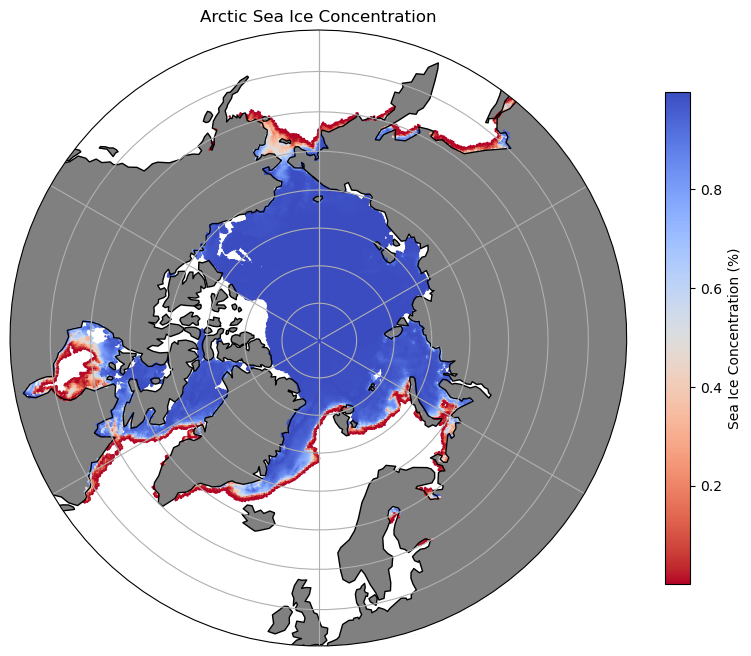

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature

da = xr.open_zarr('../data/processed/high_arctic/1.zarr')

stride = 1000
da = arctic.isel(z=slice(None, None, stride))

ice_data = da.features.loc["siconc"].values
lats = da.coords['lat'].values
lons = da.coords['lon'].values

fig = plt.figure(figsize=(10, 8))

projection = ccrs.NorthPolarStereo()
ax = plt.axes(projection=projection)
ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, facecolor='gray')
ax.coastlines(resolution='110m', zorder=2)
ax.gridlines()

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

hb = ax.hexbin(
    lons, lats,
    C=ice_data,
    gridsize=500,
    cmap='coolwarm_r',
    transform=ccrs.PlateCarree(),
    reduce_C_function=np.mean,
    mincnt=1
)

cbar = plt.colorbar(hb, ax=ax, orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label('Sea Ice Concentration (%)')

plt.title("Arctic Sea Ice Concentration")
plt.show()